In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import matplotlib.pyplot as plt
import seaborn_image as isns

import torch

from config import Environment
from denoising.data.utils import load_grayscale

isns.set_context('notebook')  # this will create thicker lines and larger fonts than usual
isns.set_image(cmap='gray', despine=True)  # set the colormap and despine the axes

In [4]:
# загружаем переменные окружения
env = Environment(_env_file='../env')

In [53]:
image = torch.Tensor(load_grayscale(env.data / 'lena.png') / 255.0)

In [54]:
def prep(x):
    mi, ma = x.min(), x.max()
    x_scaled = (x - mi) / (ma - mi) * 255.0
    return x_scaled.int().numpy()

In [102]:
fft = torch.fft.fftshift(torch.fft.fft2(image, norm='backward'), dim=(-2, -1))
fft_vis = torch.log(1 + fft.abs())

dht_vis = torch.log(1 + fft)
dht_vis = dht_vis.real - dht_vis.imag
dht_vis = torch.stack([dht_vis, dht_vis, dht_vis], axis=2)

center = tuple(s // 2 for s in dht_vis.shape[:2])
modes_h, modes_w = 16, 16
slices_x = [
    slice(center[0] - modes_h, center[0] + modes_h),
    slice(center[1] - modes_w, center[1] + modes_w),
    slice(None),
]
RED = torch.tensor([dht_vis.max(), dht_vis.min(), dht_vis.min()])
dht_vis[slices_x] = RED
print(dht_vis.max(), dht_vis.min())

fft_vis = prep(fft_vis)
dht_vis = prep(dht_vis)

tensor(11.8214) tensor(-6.0505)


In [105]:
dht_vis.max(), dht_vis.min(), dht_vis.shape

(np.int32(255), np.int32(0), (512, 512, 3))

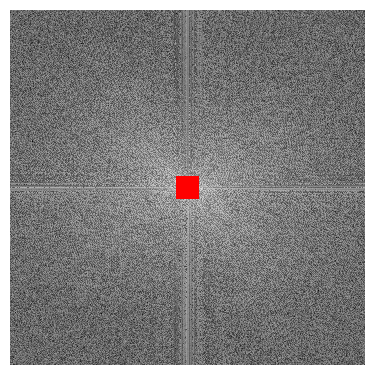

In [104]:
_ = isns.ImageGrid(
    [
        # image,
        # fft_vis,
        dht_vis,
    ],
    height=4,
    cbar=False,
)

In [48]:
import cv2

In [108]:
# cv2.imwrite('lena_fft.png', fft_vis)
cv2.imwrite('lena_dht_kmax.png', dht_vis[..., ::-1])

True

In [110]:
def imread(p):
    return cv2.imread(p)[..., ::-1]

In [126]:
img_id = '0089_004_IP_00500_00250_5500_N'
gt = imread(env.data / f'SIDD_Small_sRGB_Only/Data/{img_id}/GT_SRGB_010.PNG')
noisy = imread(env.data / f'SIDD_Small_sRGB_Only/Data/{img_id}/NOISY_SRGB_010.PNG')

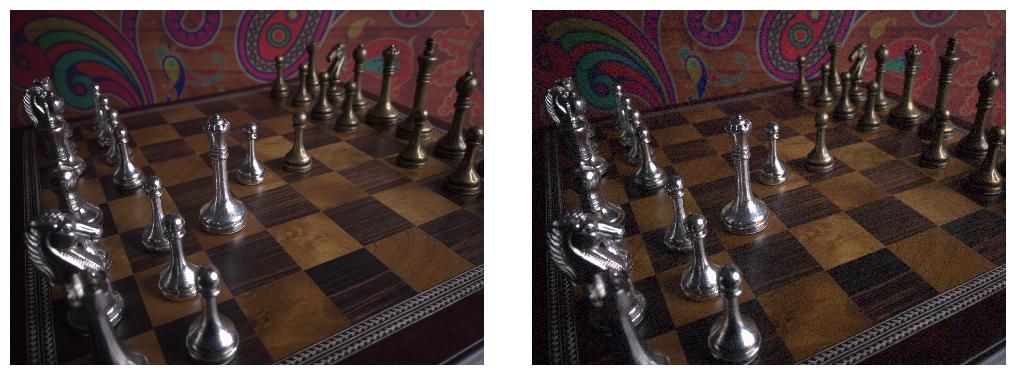

In [127]:
_ = isns.ImageGrid(
    [
        gt,
        noisy,
    ],
    height=4,
    cbar=False,
)

In [134]:
from collections import defaultdict

from tqdm import tqdm

In [136]:
shapes = defaultdict(int)
for d in tqdm((env.data / f'SIDD_Small_sRGB_Only/Data/').iterdir(), total=160):
    img = imread(d / 'GT_SRGB_010.PNG')
    shapes[img.shape] += 1
shapes

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [01:01<00:00,  2.60it/s]


defaultdict(int,
            {(3044, 4048, 3): 33,
             (3000, 5328, 3): 35,
             (3024, 4032, 3): 54,
             (2988, 5312, 3): 16,
             (3120, 4208, 3): 22})

In [169]:
import numpy as np

from denoising import DatasetRegistry
from config import get_datasets_configs

In [141]:
reg = DatasetRegistry()
reg.load(get_datasets_configs(env.data), verbose=True)

Got n_samples = 8380  in dataset mri_pm_train        with sample size = torch.Size([1, 145, 145])
Got n_samples = 2093  in dataset mri_pm_test         with sample size = torch.Size([1, 145, 145])
Got n_samples = 6704  in dataset mri_gt_train        with sample size = torch.Size([1, 145, 145])
Got n_samples = 1676  in dataset mri_gt_val          with sample size = torch.Size([1, 145, 145])
Got n_samples = 2093  in dataset mri_gt_test         with sample size = torch.Size([1, 145, 145])
Got n_samples = 137   in dataset bsd_synth_0.01_train with sample size = torch.Size([1, 321, 481])
Got n_samples = 77    in dataset bsd_synth_0.01_test with sample size = torch.Size([1, 321, 481])
Got n_samples = 12296 in dataset sidd_train          with sample size = torch.Size([3, 512, 512])
Got n_samples = 3008  in dataset sidd_test           with sample size = torch.Size([3, 512, 512])


In [162]:
dset = reg['mri_gt_train']

In [163]:
sample = dset[10]
x, y = sample['x'].squeeze().numpy(), sample['y'].squeeze().numpy()

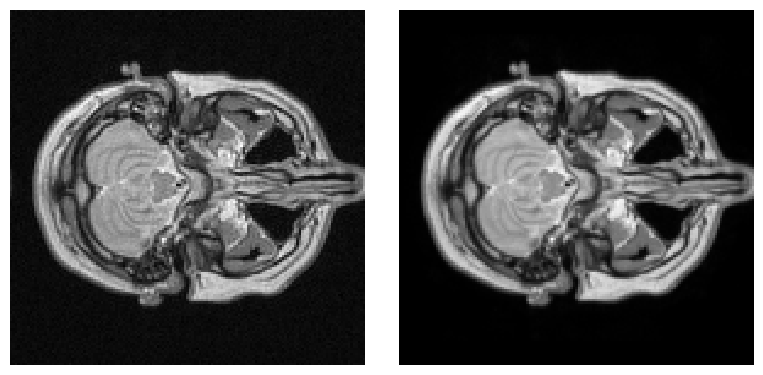

In [164]:
_ = isns.ImageGrid(
    [
        x,
        y,
    ],
    height=4,
    cbar=False,
)

In [171]:
def prep_np(x):
    return np.clip(x * 255, 0, 255).astype(np.uint)

In [172]:
cv2.imwrite('mri_example_gt.png', prep_np(x))
cv2.imwrite('mri_example_noisy.png', prep_np(y))

True